# Case 2. Pneumonia X-ray image analysis

Diresh Shrestha

Nikita Zaitcev

Trukhliaev Eduard

01.03.2020

### Helsinki Metropolia University of Applied Sciences

This document was created for learning how to use convolutional neural networks to classify medical
images

The task was to create a binary classifier for x-ray chest
images using convolutional neural networks

### Main objectives:

1) Create 3 different CNN models.

3) Compare their results using tensorflow.keras.metrics SensitivityAtSpecificity

2) Receive specificity level at least 90 % (0.90).

4) Calculate the classification report.

5) Calculate confusion matrices for the outcomes.

6) Select the best model and give reasons for selection.

# Importing Libraries

In [1]:
%pylab inline 
import os
from tensorflow import keras
from tensorflow.keras.metrics import Accuracy, SensitivityAtSpecificity, FalseNegatives, FalsePositives
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import time

Populating the interactive namespace from numpy and matplotlib


# Setting up directories

In [2]:
#Setting up the directories for our training, validation and testing data sets
train_dir = 'ChestXRay/pneumonia/train'
valid_dir = 'ChestXRay/pneumonia/validation'
test_dir = 'ChestXRay/pneumonia/test'

# Data Augmentation
In order to prevent overfitting, we will augment our data via a number of transformations available through the keras.preprocessing.image.ImageDataGenerator class. This will help generalize the model better.

In [3]:
#configure random transformations and normalization operations to be done on the images during training

train_datagen = ImageDataGenerator(rescale = 1./255, #Rescale the pixel intensities so they're in the range from 0 to 1.
                                   rotation_range=8, #range within which to randomly rotate picture(0-180).
                                  width_shift_range=0.2,  #width and height shift range are ranges within which to randomly translate
                                  height_shift_range=0.2, #pictures horizontally or vertically
                                  shear_range=0.2,  #randomly applying shearing transformations(linear map that displaces each point in fixed direction)
                                  zoom_range=0.2,  #randomly zooming inside pictures
                                  horizontal_flip=True,  #randomly flipping half of the images horizontally
                                  fill_mode='nearest')  #filling in newly created pixels

#Since we only should augment data on the training images, we only rescale the images for validation and testing
#We will be using test_datagen for validation and testing
test_datagen = ImageDataGenerator(rescale = 1./255)

## Generator

In [4]:
image_size = (150,150)  #size of the images
BS = 16 #batch_size

#implement our picture generators 
#We used Simo's dataset from kaggle which was split into Training, Validation and Testing
print('Training: ')
train_generator = train_datagen.flow_from_directory(train_dir, #target training directory
                                                   target_size=image_size,  #the size of the input image
                                                   batch_size=BS, 
                                                   class_mode='binary',  #only two classes to predict, hence binary
                                                   shuffle=True, #shuffle the order of the images that is being yielded
                                                   seed=42)  

print('Validation: ')
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size=image_size,  
                                                   batch_size=BS, 
                                                   class_mode='binary',  
                                                   shuffle=False, #do not shuffle the order of the images that is being yielded
                                                   seed=42)

print('Testing: ')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                   batch_size=BS, 
                                                   class_mode='binary', 
                                                   shuffle=False, 
                                                   seed=42)



Training: 
Found 3513 images belonging to 2 classes.
Validation: 
Found 1172 images belonging to 2 classes.
Testing: 
Found 1171 images belonging to 2 classes.


In [5]:
#Testing the train generator
i=0
for data_batch, labels_batch in train_generator:
    print('Data batch shape: ', data_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    i += 1
    if i>5:
        break

Data batch shape:  (16, 150, 150, 3)
Labels batch shape:  (16,)
Data batch shape:  (16, 150, 150, 3)
Labels batch shape:  (16,)
Data batch shape:  (16, 150, 150, 3)
Labels batch shape:  (16,)
Data batch shape:  (16, 150, 150, 3)
Labels batch shape:  (16,)
Data batch shape:  (16, 150, 150, 3)
Labels batch shape:  (16,)
Data batch shape:  (16, 150, 150, 3)
Labels batch shape:  (16,)


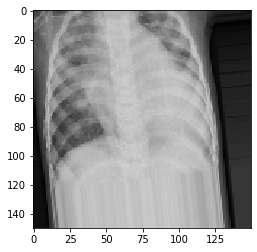

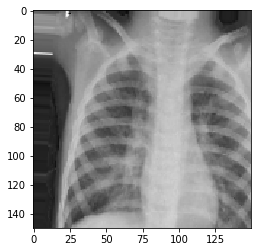

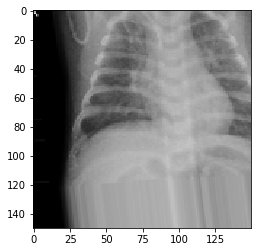

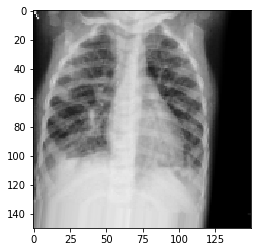

In [6]:
#Checking the first 4 images from the batch
#The image has been resized to 150x150 and random data augmentations have been applied
imshow(data_batch[0])
show()
imshow(data_batch[1])
show()
imshow(data_batch[2])
show()
imshow(data_batch[3])
show()

In [7]:
#Checking the labels
labels_batch

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

# First CNN

In our first model, we started with a large network. This serves both to augment the capacity of the network and to reduce the size of the feature maps so they aren't overly large when we reach the Flatten layer. This architecture is pretty standard and also the one used by Chollet in his book so we figured this would be a good starting point.

In [8]:
#Third CNN model

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150, 3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(512, activation ='relu'))

model1.add(layers.Dense(1, activation = 'sigmoid'))

model1.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Compilation

In [9]:
#Creating a list of metrics beforehand
#The assignment asks to use SensitivityAtSpecificity to evaluate results, but here we also check the accuracy, falsenegatives and falsepositives
my_metrics = [SensitivityAtSpecificity(0.9), Accuracy(), FalseNegatives(), FalsePositives()]

#We use binary_crossentropy as the loss function since it's best for binary classification
#We chose adam as the optimizer as it performs better than RMSprop 
model1.compile(loss='binary_crossentropy', optimizer = 'adam',
             metrics = my_metrics)

## Fit

In [10]:
%%time
#This will give us the total time taken to train the model


#Calculating the steps_per_epoch and validation_steps
#Based on some internet research, apparentyly this is best practice to calculate the steps per epoch and the validation steps
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#For consistency, we intialize the number of epochs here
epochs_amount  = 15

#Training the model
#We use the fit method instead of fit_generator because fit_generator is soon to be deprecated based on the warning and fit works with generators
h1 = model1.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        verbose = 0,
                        epochs = epochs_amount,
                        validation_data = valid_generator,
                        validation_steps=STEP_SIZE_VALID)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Wall time: 17min 9s


## Plotting

In [11]:
#Saving all the metrics
hh1 = h1.history

#Preparing them for plotting
acc1 = hh1['accuracy']
val_acc1 = hh1['val_accuracy']
fn1 = hh1['false_negatives']
val_fn1 = hh1['val_false_negatives']
fp1 = hh1['false_positives']
val_fp1 = hh1['val_false_positives']
loss1 = hh1['loss']
val_loss1 = hh1['val_loss']
sas1 = hh1['sensitivity_at_specificity']
val_sas1 = hh1['val_sensitivity_at_specificity']
epochs1 = range(len(loss1))

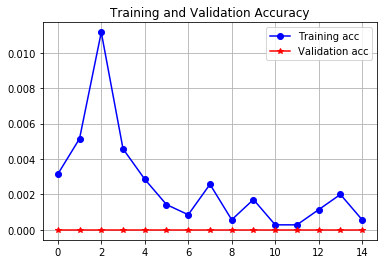

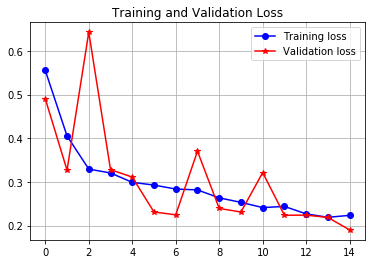

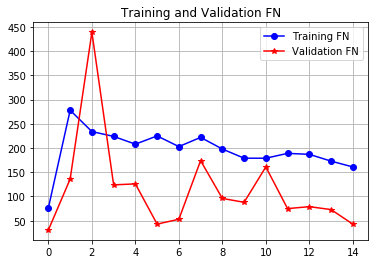

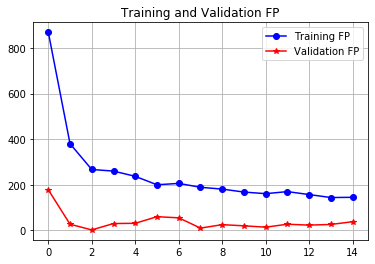

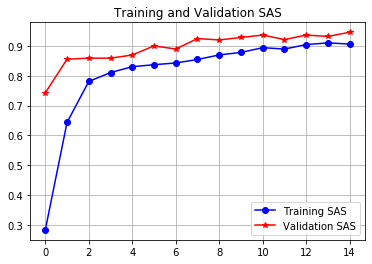

In [12]:
#Plotting the training and validatoin accuracy
plt.plot(epochs1, acc1, 'bo-', label='Training acc')
plt.plot(epochs1, val_acc1, 'r*-', label='Validation acc')
title('Training and Validation Accuracy')
grid()
legend()


#Plotting the training and validation loss
figure()
plt.plot(epochs1, loss1, 'bo-', label='Training loss')
plt.plot(epochs1, val_loss1, 'r*-', label='Validation loss')
title('Training and Validation Loss')
grid()
legend()

#Plotting the training and validation False Negatives
figure()
plt.plot(epochs1, fn1, 'bo-', label='Training FN')
plt.plot(epochs1, val_fn1, 'r*-', label='Validation FN')
title('Training and Validation FN')
grid()
legend()

#Plotting the training and validation False Negatives
figure()
plt.plot(epochs1, fp1, 'bo-', label='Training FP')
plt.plot(epochs1, val_fp1, 'r*-', label='Validation FP')
title('Training and Validation FP')
grid()
legend()

#Plotting the training and validation Sensitivity At Specificity

figure()
plt.plot(epochs1, sas1, 'bo-', label='Training SAS')
plt.plot(epochs1, val_sas1, 'r*-', label='Validation SAS')
title('Training and Validation SAS')
grid()
legend()
show()

## Predicting

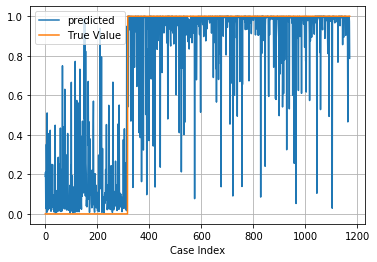

In [13]:
#Finding the labels
labels1 = test_generator.classes

#Predicting the results
predicted1 = model1.predict(test_generator).flatten()

#Plotting the predicted and true labels as lists
plt.plot(predicted1, label = 'predicted')
plt.plot(labels1, label = 'True Value')
legend()
xlabel('Case Index')
grid()

In [14]:
#Calculating confusion matrix and classification report using scikit learn libriary
#Originaly we cant do this without some 'filter', because we cant`t compare binary and float numbers
#So we make that all our variables that are bigger than 0.5 become 1 and smaller than that become 0
#We picked 0.5 based on the figure above as 0.5 seemed like a good threshold
print('Confusion matrix (machine learning way):')
cm1 = confusion_matrix(labels1, predicted1 >0.5)
print(cm1)
tn1, fp1, fn1, tp1 = confusion_matrix(labels1, predicted1 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp1, fn1], [fp1, tn1]]))

cr1 = classification_report(labels1, predicted1 > 0.5, target_names = ['Normal(0)', 'Pneumonia(1)'])
print(cr1)

Confusion matrix (machine learning way):
[[293  24]
 [ 33 821]]
Confusion matrix (medicine way):
[[821  33]
 [ 24 293]]
              precision    recall  f1-score   support

   Normal(0)       0.90      0.92      0.91       317
Pneumonia(1)       0.97      0.96      0.97       854

    accuracy                           0.95      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.95      0.95      0.95      1171



# Second CNN

In this model we decided to start with small convolutional layer with bigger filter size. Also we decided to decrease frist dense layer. This architecture was partly inspired by the classical LeNet architecture.

In [15]:
#Second CNN model
model2 = models.Sequential()
model2.add(layers.Conv2D(6, (5,5), activation='relu', input_shape=(150,150, 3)))
model2.add(layers.MaxPooling2D((2,2), strides=2))
model2.add(layers.Conv2D(16, (5,5), activation = 'relu'))
model2.add(layers.MaxPooling2D((2,2), strides=2))
model2.add(layers.Conv2D(120, (5,5), activation = 'relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(84, activation ='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(1, activation = 'sigmoid'))

model2.summary()

model2.compile(loss='binary_crossentropy', optimizer = 'adam',
             metrics = my_metrics)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 146, 146, 6)       456       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 69, 69, 16)        2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 120)       48120     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 120)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27000)            

In [16]:
%%time
#we calculate time and run our model
h2 = model2.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        verbose = 0,
                        epochs=epochs_amount,
                        validation_data = valid_generator,
                        validation_steps=STEP_SIZE_VALID)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Wall time: 17min 9s


We repeat same steps for visualizing our result

In [17]:
hh2 = h2.history
acc2 = hh2['accuracy']
val_acc2 = hh2['val_accuracy']
fn2 = hh2['false_negatives']
val_fn2 = hh2['val_false_negatives']
fp2 = hh2['false_positives']
val_fp2 = hh2['val_false_positives']
loss2 = hh2['loss']
val_loss2 = hh2['val_loss']
sas2 = hh2['sensitivity_at_specificity']
val_sas2 = hh2['val_sensitivity_at_specificity']
epochs2 = range(len(loss2))

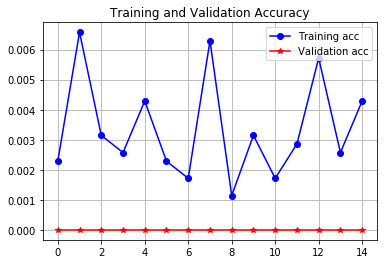

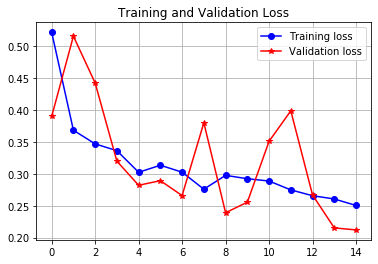

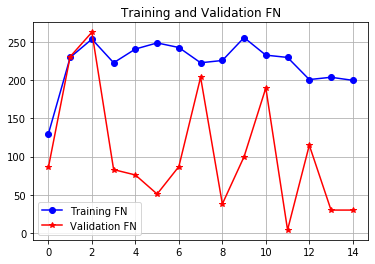

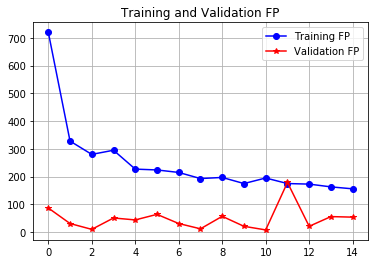

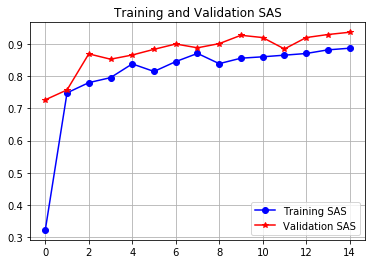

In [18]:
plt.plot(epochs2, acc2, 'bo-', label='Training acc')
plt.plot(epochs2, val_acc2, 'r*-', label='Validation acc')
title('Training and Validation Accuracy')
grid()
legend()

figure()
plt.plot(epochs2, loss2, 'bo-', label='Training loss')
plt.plot(epochs2, val_loss2, 'r*-', label='Validation loss')
title('Training and Validation Loss')
grid()
legend()

figure()
plt.plot(epochs2, fn2, 'bo-', label='Training FN')
plt.plot(epochs2, val_fn2, 'r*-', label='Validation FN')
title('Training and Validation FN')
grid()
legend()

figure()
plt.plot(epochs2, fp2, 'bo-', label='Training FP')
plt.plot(epochs2, val_fp2, 'r*-', label='Validation FP')
title('Training and Validation FP')
grid()
legend()

figure()
plt.plot(epochs2, sas2, 'bo-', label='Training SAS')
plt.plot(epochs2, val_sas2, 'r*-', label='Validation SAS')
title('Training and Validation SAS')
grid()
legend()
show()

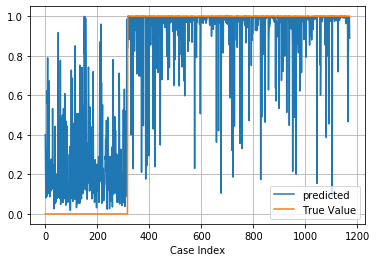

In [19]:
labels2 = test_generator.classes

predicted2 = model2.predict(test_generator).flatten()

plt.plot(predicted2, label = 'predicted')
plt.plot(labels2, label = 'True Value')
legend()
xlabel('Case Index')
grid()

In [22]:
print('Confusion matrix (machine learning way):')
cm2 = confusion_matrix(labels2, predicted2 >0.5)
print(cm2)
tn2, fp2, fn2, tp2 = confusion_matrix(labels2, predicted2 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp2, fn2], [fp2, tn2]]))
cr2 = classification_report(labels2, predicted2 > 0.5, target_names = ['Normal(0)', 'Pneumonia(1)'])
print(cr2)

Confusion matrix (machine learning way):
[[267  50]
 [ 33 821]]
Confusion matrix (medicine way):
[[821  33]
 [ 50 267]]
              precision    recall  f1-score   support

   Normal(0)       0.89      0.84      0.87       317
Pneumonia(1)       0.94      0.96      0.95       854

    accuracy                           0.93      1171
   macro avg       0.92      0.90      0.91      1171
weighted avg       0.93      0.93      0.93      1171



## Third CNN

In our final model, we tried to understand what the parameters mean. We figured that 2 convolutional and 2 maxpool layers should be enough to solve a classification problem of this kind. After which we recieve image dimensions of 6x6x64 size. Basicaly, it means that now we have 2304 response variables. We looked at the AlexNet architecture and their solution for picking the number of Dense layers was pretty simple - divide amount of variables by 2 and then round to closet power of two. This is what we implemented. 

In [23]:
model3 = models.Sequential()
#Our kernel size is 2x2 and we pick stride of 2 instead of the default 1. 
#This means the filter would jump every two blocks instead of one and there would be no overlap
model3.add(layers.Conv2D(32, (2,2), strides=(2,2), activation='relu', input_shape=(150,150, 3)))
#Our first pooling layer is 3x3
model3.add(layers.MaxPooling2D((3,3)))
model3.add(layers.Conv2D(64, (2,2), strides=(2,2), activation = 'relu'))
#The second pooling layer we chose 2x2 which is pretty standard
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
#We decided to have 2 dense layers with the same number of neurons because it performed better during our experimentation
model3.add(layers.Dense(1024, activation ='relu'))
model3.add(layers.Dense(1024, activation ='relu'))
#This dropout layer prevents overfitting 
#We dropout 40% of the features 
model3.add(layers.Dropout(0.4))
model3.add(layers.Dense(1, activation = 'sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 75, 75, 32)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)             

In [28]:

model3.compile(loss='binary_crossentropy', optimizer = 'adam',
             metrics = my_metrics)

In [29]:
%%time 
h3 = model3.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        verbose=0,
                        epochs=epochs_amount,
                        validation_data = valid_generator,
                        validation_steps=STEP_SIZE_VALID)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Wall time: 17min 17s


In [30]:
hh3 = h3.history


acc3 = hh3['accuracy']
val_acc3 = hh3['val_accuracy']
fn3 = hh3['false_negatives']
val_fn3 = hh3['val_false_negatives']
fp3 = hh3['false_positives']
val_fp3 = hh3['val_false_positives']
loss3 = hh3['loss']
val_loss3 = hh3['val_loss']
sas3 = hh3['sensitivity_at_specificity']
val_sas3 = hh3['val_sensitivity_at_specificity']
epochs3 = range(len(loss3))

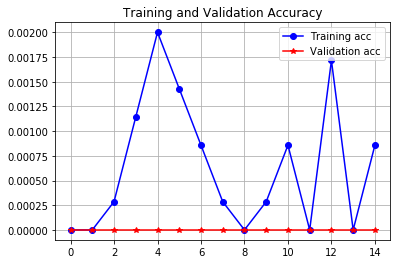

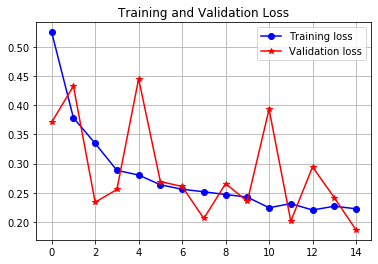

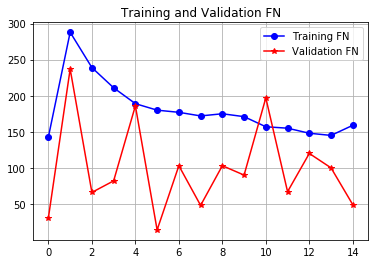

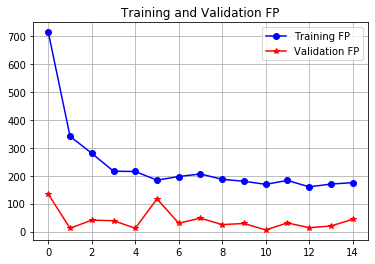

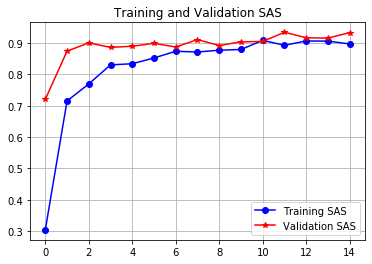

In [31]:

plt.plot(epochs3, acc3, 'bo-', label='Training acc')
plt.plot(epochs3, val_acc3, 'r*-', label='Validation acc')
title('Training and Validation Accuracy')
grid()
legend()

figure()
plt.plot(epochs3, loss3, 'bo-', label='Training loss')
plt.plot(epochs3, val_loss3, 'r*-', label='Validation loss')
title('Training and Validation Loss')
grid()
legend()


figure()
plt.plot(epochs3, fn3, 'bo-', label='Training FN')
plt.plot(epochs3, val_fn3, 'r*-', label='Validation FN')
title('Training and Validation FN')
grid()
legend()


figure()
plt.plot(epochs3, fp3, 'bo-', label='Training FP')
plt.plot(epochs3, val_fp3, 'r*-', label='Validation FP')
title('Training and Validation FP')
grid()
legend()

figure()
plt.plot(epochs3, sas3, 'bo-', label='Training SAS')
plt.plot(epochs3, val_sas3, 'r*-', label='Validation SAS')
title('Training and Validation SAS')
grid()
legend()
show()

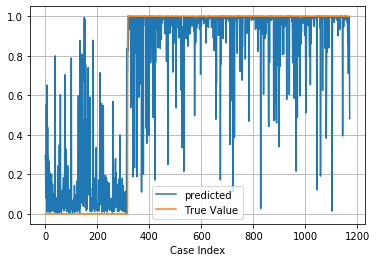

In [38]:
labels3 = test_generator.classes

predicted3 = model3.predict(test_generator).flatten()


plt.plot(predicted3, label = 'predicted')
plt.plot(labels3, label = 'True Value')
legend()
xlabel('Case Index')
grid()


In [39]:
print('Confusion matrix (machine learning way):')
cm3 = confusion_matrix(labels3, predicted3 >0.5)
print(cm3)
tn3, fp3, fn3, tp3 = confusion_matrix(labels3, predicted3 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp3, fn3], [fp3, tn3]]))
cr3 = classification_report(labels3, predicted3 > 0.5, target_names = ['Normal(0)', 'Pneumonia(1)'])
print(cr3)

Confusion matrix (machine learning way):
[[292  25]
 [ 35 819]]
Confusion matrix (medicine way):
[[819  35]
 [ 25 292]]
              precision    recall  f1-score   support

   Normal(0)       0.89      0.92      0.91       317
Pneumonia(1)       0.97      0.96      0.96       854

    accuracy                           0.95      1171
   macro avg       0.93      0.94      0.94      1171
weighted avg       0.95      0.95      0.95      1171



# Sensitivity and Specificity

In [40]:
#Calculating sensitivity and specifity for all our models
sensitivity1 = cm1[0][0]/(cm1[0][0] + cm1[0][1])
specificity1 = cm1[1][1]/(cm1[1][0]+cm1[1][1])


sensitivity2 = cm2[0][0]/(cm2[0][0] + cm2[0][1])
specificity2 = cm2[1][1]/(cm2[1][0]+cm2[1][1])


sensitivity3 = cm3[0][0]/(cm3[0][0] + cm3[0][1])
specificity3 = cm3[1][1]/(cm3[1][0]+cm3[1][1])

accuracy1 = (cm1[0][0] + cm1[1][1])/1171
accuracy2 = (cm2[0][0] + cm2[1][1])/1171
accuracy3 = (cm3[0][0] + cm3[1][1])/1171

print("Sensitivity for the first model on the test set: ", sensitivity1)
print("Specificity for the first model on the test set: ", specificity1)
print("Accuracy for the first model on the test set: ", accuracy1)

print("Sensitivity for the second model on the test set: ", sensitivity2)
print("Specificity for the second model on the test set: ", specificity2)
print("Accuracy for the second model on the test set: ", accuracy2)

print("Sensitivity for the third model on the test set: ", sensitivity3)
print("Specificity for the third model on the test set: ", specificity3)
print("Accuracy for the third model on the test set: ", accuracy3)

Sensitivity for the first model on the test set:  0.9242902208201893
Specificity for the first model on the test set:  0.9613583138173302
Accuracy for the first model on the test set:  0.9513236549957301
Sensitivity for the second model on the test set:  0.8422712933753943
Specificity for the second model on the test set:  0.9613583138173302
Accuracy for the second model on the test set:  0.9291204099060631
Sensitivity for the third model on the test set:  0.9211356466876972
Specificity for the third model on the test set:  0.9590163934426229
Accuracy for the third model on the test set:  0.9487617421007686


As we can see first and third models have almost similar results and perform better than the second model.

## ROC Curve

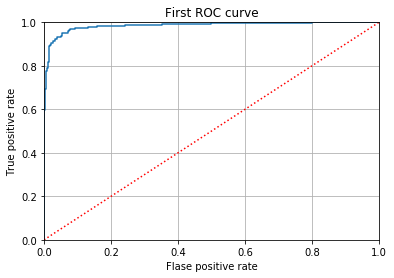

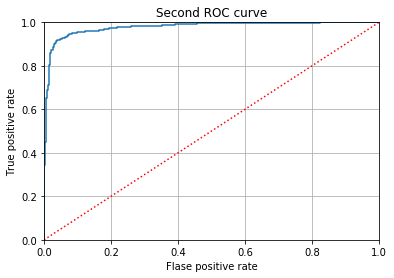

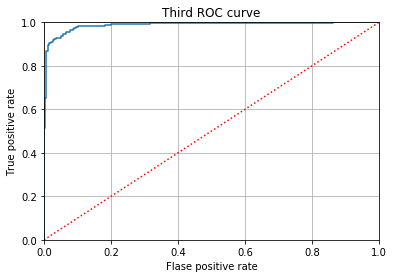

In [41]:
from sklearn.metrics import roc_curve

#The ROC curve plots sensitivity(recall) versus 1-specificity
#A good classifier stays as far away to the top left as possible from the middle line

fpr1, tpr1, thresholds1 = roc_curve(labels1, predicted1, pos_label=1)

#plotting curves
plt.plot(fpr1, tpr1)
plt.plot([0,1], [0,1], 'r:')
xlabel('Flase positive rate')
ylabel('True positive rate')
title('First ROC curve')
xlim([0,1])
ylim([0,1])
grid()

fpr2, tpr2, thresholds2 = roc_curve(labels2, predicted2, pos_label=1)
figure()
plt.plot(fpr2, tpr2)
plt.plot([0,1], [0,1], 'r:')
xlabel('Flase positive rate')
ylabel('True positive rate')
title('Second ROC curve')
xlim([0,1])
ylim([0,1])
grid()

fpr3, tpr3, thresholds3 = roc_curve(labels3, predicted3, pos_label=1)
figure()
plt.plot(fpr3, tpr3)
plt.plot([0,1], [0,1], 'r:')
xlabel('Flase positive rate')
ylabel('True positive rate')
title('Third ROC curve')
xlim([0,1])
ylim([0,1])
grid()

In [43]:
#A perfect classifier will have an area under the curve of 1
from sklearn.metrics import roc_auc_score

#Getting the area under the curve for the three roc curves
roc_auc1 = roc_auc_score(labels1, predicted1)
roc_auc2 = roc_auc_score(labels2, predicted2)
roc_auc3 = roc_auc_score(labels3, predicted3)
#Printing result
print("The area under the curve of the ROC curve for the first model: ", roc_auc1)
print("The area under the curve of the ROC curve for the second model: ", roc_auc2)
print("The area under the curve of the ROC curve for the third model: ", roc_auc3)

The area under the curve of the ROC curve for the first model:  0.9849474360773942
The area under the curve of the ROC curve for the second model:  0.9781876343649111
The area under the curve of the ROC curve for the third model:  0.987895152889723


The area under the curve is highest for the third model.

# Conclusion

In [60]:
print('The Sensitivity at Specificity of the first model: ', sas1[14])
print('The Sensitivity at Specificity of the second model: ', sas2[14])
print('The Sensitivity at Specificity of the third model: ', sas3[14])

The Sensitivity at Specificity of the first model:  0.9062745
The Sensitivity at Specificity of the second model:  0.8859271
The Sensitivity at Specificity of the third model:  0.89690316


The first model and the third model has very similar results overall. The first model's Sensitivity at Specificity is slightly higher than the third model's however, the third model's area under the ROC curve is slightly higher. Since, the first model was copied from Chollet's book, we have decided that the third model that we came up with on our own performed similarly if not better. Therefore, we pick the third model as the best. 